In [18]:
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import itertools
# Sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import datasets
from nltk.corpus import stopwords
import nltk
import seaborn as sn
from collections import Counter
from gensim.sklearn_api.w2vmodel import W2VTransformer
from gensim.sklearn_api.d2vmodel import D2VTransformer
from itertools import chain
from decimal import Decimal
from IPython.display import display, HTML
from ast import literal_eval
import xlrd
import openpyxl

In [2]:
def row(key, scores, params):
            d = {
                 'estimator': key,
                 'mean_score': np.mean(scores),
                 'f1-scores': scores,
            }
            return pd.Series({**params,**d})
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [3]:
# Importing data
df = pd.read_csv("Handelingen.csv", index_col=0)
df = df.loc[df['speech category'] == 'Main Speech']

## FIX THIS INTO ONE LINE
df.list_text = df.text.apply(lambda x: [stemmer.stem(t) for t in tokenizer.tokenize(x)])
df.normal_text = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df.head(5)

,surname,party,text,file,speech category,date,tags
107136,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']"
107137,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']"
107138,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']"
107139,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']"
107148,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']"


# Data Info

In [4]:
countdf = df.party.value_counts()
with open("Verslag/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=False))
countdf

SP              2573
PvdA            2269
CDA             2216
D66             2211
VVD             2157
PVV             1880
ChristenUnie    1223
GroenLinks      1193
SGP              770
PvdD             480
50PLUS           413
Name: party, dtype: int64

In [5]:
tekst = chain.from_iterable([list(set(doc)) for doc in df.list_text])
count = Counter(tekst)
samples = list(count.values())

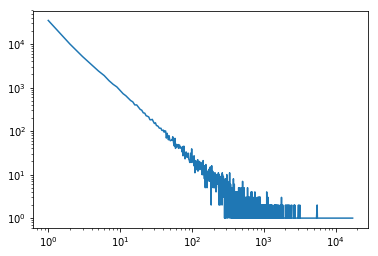

In [6]:
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

In [7]:
tekst = [len(doc) for doc in df.list_text]

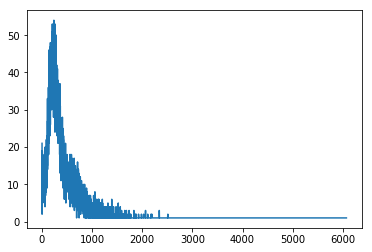

In [8]:
t = Counter(tekst)
t = sorted(t.items())
x, y = zip(*t)
plt.plot(x, y)
plt.show()

# Models

In [9]:
def modelsdownload():
    models_df = pd.read_excel('Models.xlsx', index_col=0)
    models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier,models_df.PIPELINE):
        exec(compile("a="+y,'','exec'),globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict
def modelsdownload2():
    models_df = pd.read_excel('Models.xlsx', index_col=0)
    models_dict = {}
    for x,y in zip(models_df.Classifier,models_df.PIPELINE):
        exec(compile("a="+y,'','exec'),globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [10]:
models_df, models_dict = modelsdownload()
    
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis =1)
    temp_dict = {}
    for x,y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x,y in zip(models_df.Classifier, models_df.RAW)}

In [11]:
for name,pipe in models_dict.items():
    if text_dict[name]:
         text = list(df.list_text)
    else:
        text = list(df.normal_text)
    gs = GridSearchCV(pipe, params_dict[name], cv=5, scoring='f1_weighted')
    gs.fit(text, df.party)
    rows = [row(name, gsc.cv_validation_scores, gsc.parameters) for gsc in gs.grid_scores_]
    df2 = pd.concat(rows, axis=1).T
    pd.concat([df2, pd.read_csv('Scores.csv', index_col=0)], ignore_index=True).sort_values(['mean_score'], ascending=False).to_csv('Scores.csv')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df.Classifier==name,"DOEN"] = False
    df4.to_excel('Models.xlsx')
    
#https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [12]:
scores = pd.read_csv('Scores.csv', index_col=0).head(1)
scores = scores.dropna(axis=1).reset_index(drop=True)
scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])

In [13]:
models_df, models_dict = modelsdownload2()
pipe = models_dict[scores.estimator[0]]
pipe.set_params(**scores.drop([col for col in scores.columns if "__" not in col], axis=1).to_dict(orient='records')[0])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99999999, max_features=None, min_df=0.001,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=...cnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

In [14]:
#source: https://stackoverflow.com/questions/17260109/sample-two-pandas-dataframes-the-same-way/17260475
#df = pd.read_csv("Handelingen.csv", index_col=0)
#df = df.loc[df['speech category'] == 'Main Speech']
#df = df.reset_index(drop=True)
#df.tekst = df.text.apply(lambda x: ' '.join([sbs.stem(t) for t in tokenizer.tokenize(x)]))
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
pipe.fit(list(df_train.text), list(df_train.party))
predicted = pipe.predict(df_test.text)
classification_report(df_test.party, predicted)

'              precision    recall  f1-score   support\n\n      50PLUS       0.94      0.85      0.89        73\n         CDA       0.80      0.76      0.78       486\nChristenUnie       0.78      0.74      0.76       257\n         D66       0.77      0.73      0.75       443\n  GroenLinks       0.90      0.69      0.78       239\n         PVV       0.78      0.81      0.80       384\n        PvdA       0.62      0.69      0.65       433\n        PvdD       0.87      0.83      0.85        94\n         SGP       0.85      0.77      0.81       151\n          SP       0.73      0.80      0.76       515\n         VVD       0.67      0.72      0.69       402\n\n avg / total       0.76      0.75      0.75      3477\n'

In [15]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

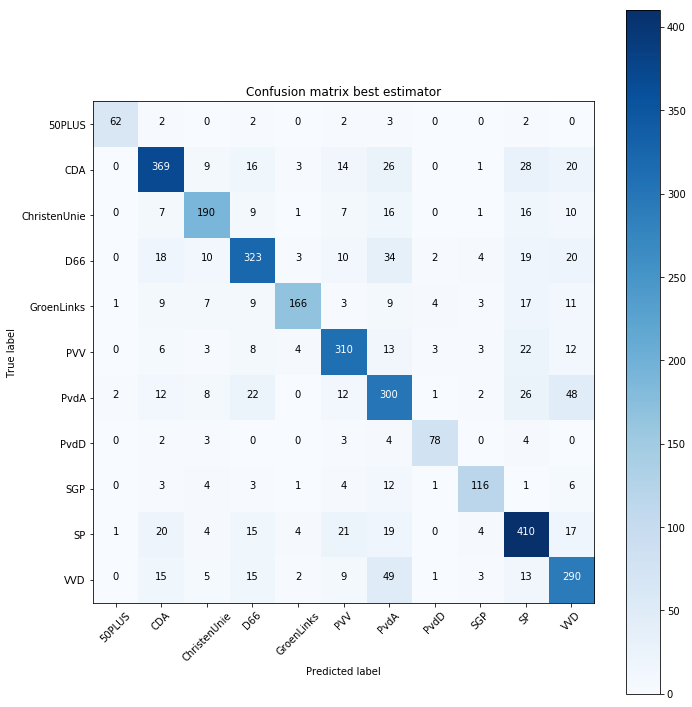

In [19]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.show()

# Git

In [ ]:
!git pull
!git add CompleteNotebook.ipynb
!git add Bestscore.ipynb
!git add Scraper.ipynb
!git add Scores.csv
!git add Verslag/Scriptie_Sprekers_TK.pdf
!git add Verslag/Spreekbeurten.tex
!git add Verslag/MItable.tex
!git add Models.xlsx
!git commit -m Update
!git push